In [1]:
## General libraries
import numpy as np
import tensorflow as tf
import pandas as pd
import collections
import math
import pprint
import pickle

## My libraries 
import comms

In [2]:
## Optimization Settings  
counts_alg = "A"
genbatch_alg = "A"
batch_size = 32
embedding_size = 32
num_sampled = 16
num_iter = 50000

** Load and format data to sessions and make test and train set **

In [3]:
date_bags_train, word_bags_train, context_ids_train = pickle.load( open( "train_sessions.pkl", "rb" ) )
date_bags_test, word_bags_test, context_ids_test = pickle.load( open( "test_sessions.pkl", "rb" ) )

** Generate data for training the model **

In [4]:
## 1) context == all data of one user 
word_bags_all_per_user = [[w for wb in word_bag for w in wb] for word_bag in word_bags_train] ## np.sum(np.array([len(w)<2 for w in word_bags_all_per_user]))

## 2) context = one user session 
word_bags_all_per_sess = [wb for word_bag in word_bags_train for wb in word_bag]
word_bags_all_per_sess = [wb for wb in word_bags_all_per_sess if len(wb) >= 2] ## np.sum(np.array([len(x)<2 for x in word_bags_all_per_sess]))

** Dict and batch gen **

In [5]:
dictionary, reversed_dictionary = comms.create_dictionary(word_bags_all_per_sess, counts_alg)

## Number of distinct words in vocabulary
vocabulary_size = len(dictionary)

genbatch_prereq = comms.create_genbatch_prerequisities(word_bags_all_per_sess, dictionary)

def generate_batch(batch_size): 
    return comms.generate_batch(batch_size, genbatch_prereq, genbatch_alg) 

** Build model and train the shit out of it **

In [6]:
w2v_model = comms.create_w2v_tf_model(batch_size, embedding_size, vocabulary_size, num_sampled, learn_rate = 1.0)
train_inputs, train_labels, embeddings, nce_weights, nce_biases, loss, optimizer, init = w2v_model

In [7]:
sess = tf.Session()
sess.run(init)

In [8]:
## Learn the embeddings
for i in range(num_iter): 
    batch, labels = generate_batch(batch_size)
    _, loss_eval = sess.run([optimizer, loss], {train_inputs : batch, train_labels : labels})
    if i % 1000 == 0: 
        print("Loss at iteration",i, " : ",loss_eval)

Loss at iteration 0  :  71.623
Loss at iteration 1000  :  5.58264
Loss at iteration 2000  :  2.94636
Loss at iteration 3000  :  3.04363
Loss at iteration 4000  :  2.28525
Loss at iteration 5000  :  1.96784
Loss at iteration 6000  :  2.06146
Loss at iteration 7000  :  1.80614
Loss at iteration 8000  :  1.44121
Loss at iteration 9000  :  1.60122
Loss at iteration 10000  :  1.92824
Loss at iteration 11000  :  1.64914
Loss at iteration 12000  :  1.91471
Loss at iteration 13000  :  1.34326
Loss at iteration 14000  :  1.57373
Loss at iteration 15000  :  1.48685
Loss at iteration 16000  :  1.44834
Loss at iteration 17000  :  1.01393
Loss at iteration 18000  :  2.19043
Loss at iteration 19000  :  1.20726
Loss at iteration 20000  :  1.76911
Loss at iteration 21000  :  0.910703
Loss at iteration 22000  :  1.17176
Loss at iteration 23000  :  1.14263
Loss at iteration 24000  :  1.44065
Loss at iteration 25000  :  2.1269
Loss at iteration 26000  :  1.6555
Loss at iteration 27000  :  0.942603
Loss a

In [9]:
embeddings_eval, nce_weights_eval, nce_biases_eval = sess.run([embeddings, nce_weights, nce_biases]) 

In [45]:
model_packed = embeddings_eval, nce_weights_eval, nce_biases_eval, dictionary 
pickle.dump(model_packed, open("model_packed.pkl", "wb"))

** Test that shit **

In [10]:
wb_two_sess = [wb for wb in word_bags_test if len(wb)>=2]
wb_test_flat = [[w for wb in word_bag for w in wb] for word_bag in word_bags_test]  ## np.sum(np.array([len(x)<2 for x in wb_test_flat])) 

In [11]:
sess = wb_test_flat[25]

In [46]:
wb_test_flat

[['1085990', '1085975'],
 ['1013979', '695503'],
 ['1024557', '1024557'],
 ['903507', '823842', '1035613'],
 ['1081234', '1081234', '1081234'],
 ['1076284', '1076361'],
 ['935752', '935752', '935752'],
 ['1090007',
  '1090007',
  '1090007',
  '1090371',
  '1090371',
  '1090007',
  '1090007',
  '1062762',
  '1090007'],
 ['935804',
  '935804',
  '1058972',
  '935880',
  '1058972',
  '1058972',
  '935804',
  '935804',
  '935804',
  '935804',
  '1058972',
  '1058972'],
 ['476423',
  '476423',
  '476423',
  '476423',
  '476423',
  '476423',
  '476423',
  '1074458',
  '476423',
  '476423',
  '1059440'],
 ['1013979', '1067651', '695504', '1068768'],
 ['948145', '948145', '940658'],
 ['1028930', '1028930'],
 ['1074458', '1074458'],
 ['1054296', '920166', '920148', '920148'],
 ['1018235', '1018246', '1018627'],
 ['926110', '1084501', '926110'],
 ['1076284', '1076284', '1076284', '1076284', '1076284'],
 ['1074458', '810681'],
 ['1066700', '1081234', '1081234', '1081234', '1081234', '1081234'],
 

In [12]:
def pred_order(ind_list):
    """
    Order in which we will present item i to the user 
    
    Arguments:
    ind_list -- indices of items according to dictionary
    
    Return:
    order_presented -- vector of shape (embeddings.shape[0], ), ith entry is order in which we present ith item
    """
    mean_emb = np.mean(embeddings_eval[ind_list,:], axis=0)
    preferences = comms.softmax(np.sum(nce_weights_eval * mean_emb, axis=1) + nce_biases_eval)
    order_presented = len(preferences) - np.argsort(np.argsort(preferences)) 
    return order_presented

In [13]:
def eval_one_sess(sess, naive=False): 
    """
    sess -- list of item ids
    naive -- use naive approach for defining order, we present items that were already selected
             returns order 1 if predicted item is in past items
             returns 1000 if predicted item is not in past items
    
    """
    ind = [dictionary.get(s) for s in sess]
    ind = [i for i in ind if i != None]
    if len(ind) == 0:
        return []
    else: 
        sess_orders = []
        for j in range(1, len(ind)-1):
#             print(j,"  ", ind[0:j])
            if naive: 
                sess_orders.append(1 if ind[j] in ind[0:j] else 1000)
            else:
                sess_orders.append(pred_order(ind[0:j])[ind[j]])
    return sess_orders
            

In [14]:
evals_for_flat_users = [eval_one_sess(s, naive=False) for s in wb_test_flat]

In [43]:
evals_for_flat_users[8]

[8, 140, 1, 31, 14, 4, 4, 3, 3, 25]

In [15]:
np.percentile([1,2,3,4,5,6,7,8,9,10], q = 0.1)

1.0089999999999999

In [16]:
print("Number of testing users: ", len(wb_test_flat))
print("Number of testing users, where prediction available:", np.sum(np.array([len(x) == 0 for x in evals_for_flat_users])))
median_evals_for_flat_users = [np.median(e) for e in evals_for_flat_users if len(e) > 0]
print("Number of users that had more than half of their predictions on first page: ", np.sum(np.array([e <= 48 for e in median_evals_for_flat_users])))

Number of testing users:  500
Number of testing users, where prediction available: 216
Number of users that had more than half of their predictions on first page:  215


In [17]:
import matplotlib.pyplot as plt

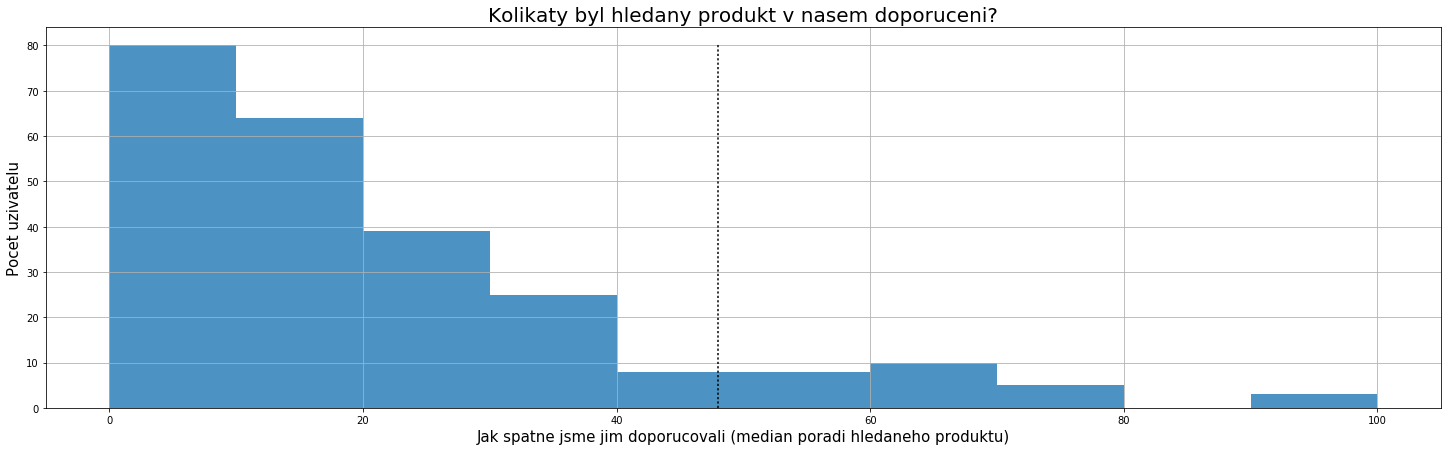

In [39]:
plt.figure(figsize=(25,7))
plt.hist(median_evals_for_flat_users, range=[0,100], alpha=0.8)
plt.title("Kolikaty byl hledany produkt v nasem doporuceni?", size = 20)
plt.xlabel("Jak spatne jsme jim doporucovali (median poradi hledaneho produktu)", size= 15)
plt.ylabel("Pocet uzivatelu", size = 15)
plt.vlines(x=48, ymin=0, ymax=80, linestyles="dotted")
plt.grid()
plt.show()